In [177]:
import numpy as np
import tiktoken
import torch
from tqdm import tqdm

def pad_data(data, length=420):
    # print(data.shape)
    try:
        # Check if padding or truncation is needed based on the time steps dimension
        if data.shape[0] < length:
            # # Only pad the first dimension (time steps), keeping the rest unchanged
            # padding = ((0, length - data.shape[0]), (0, 0), (0, 0))
            # data = np.pad(data, padding, 'constant', constant_values=data[-1])
            padding = np.zeros(
                (length - data.shape[0], data.shape[1], data.shape[2]), dtype=np.float32
            )
            padding += data[-1]
            data = np.concatenate([data, padding], axis=0)
        elif data.shape[0] > length:
            data = data[:length]
        return data
    except Exception as e:
        print("data:", data)
        print("length:", length)
        print("data.shape:", data.shape)
        print(e)


def get_encoding(text, enc=None, tokenizer_name='gpt-4'):
    if enc is None:
        enc = tiktoken.encoding_for_model(tokenizer_name)
    return np.array(enc.encode(text)).astype(np.int32)


base_paths = dict(
    text = 'HumanML3D/HumanML3D/texts/',
    motion = 'HumanML3D/HumanML3D/new_joints/',
)

train_file_nums = np.genfromtxt('HumanML3D/HumanML3D/train_cleaned.txt', delimiter='\n', dtype=str)
test_file_nums = np.genfromtxt('HumanML3D/HumanML3D/test_cleaned.txt', delimiter='\n', dtype=str)
val_file_nums = np.genfromtxt('HumanML3D/HumanML3D/val_cleaned.txt', delimiter='\n', dtype=str)

print('train:', train_file_nums.shape, 'test:', test_file_nums.shape, 'val:', val_file_nums.shape)

all_file_numbers = np.concatenate([train_file_nums, test_file_nums, val_file_nums])

tokenizer = 'gpt-4'
enc = tiktoken.encoding_for_model(tokenizer)

for t, file_nums in zip('train test val'.split(), [train_file_nums, test_file_nums, val_file_nums]):
    for file_num in tqdm(file_nums, desc=t):
        data = {}

        #### MOTION ####
        motion = np.load(base_paths['motion'] + file_num + '.npy')
        motion = pad_data(motion, length=120)
        data['motion'] = motion

        pose0 = motion[:1]
        root = motion[:, :1, :]
        # root_travel = root_travel - root_travel[:1]  # relative to the first frame
        motion_less_root = motion - root# relative motion
        velocity = np.diff(motion, axis=0)
        velocity_relative = np.diff(motion_less_root, axis=0)

        data['pose0'] = pose0
        data['root'] = root
        data['motion_less_root'] = motion_less_root
        data['velocity'] = velocity
        data['velocity_relative'] = velocity_relative

        ##### TEXT #####
        with open(base_paths['text'] + file_num + '.txt', 'r') as f:
            texts = f.readlines()
        # texts = np.genfromtxt(base_paths['text'] + file_num + '.txt', delimiter='\n', dtype=str)
        if type(texts) == np.str_ or type(texts) == str:
            texts = [texts]
        # remove empty strings
        # print(texts, type(texts))
        texts = np.array([t for t in texts if t != ''])    
    

        data['texts'] = {}
        data['texts_encoded'] = {}

        for tn, text in enumerate(texts):
            encoding = get_encoding(text, enc)
            
            data['texts'][tn] = text
            data['texts_encoded'][tn] = encoding

        np.savez_compressed(f'data_fully_preprocessed/{t}/{file_num}.npz', **data)

    print(f'{t} done')
    




train: (16429,) test: (3064,) val: (1046,)


train:   0%|          | 0/16429 [00:00<?, ?it/s]

train: 100%|██████████| 16429/16429 [01:18<00:00, 207.98it/s]


train done


test: 100%|██████████| 3064/3064 [00:14<00:00, 212.28it/s]


test done


val: 100%|██████████| 1046/1046 [00:04<00:00, 212.33it/s]

val done


In [174]:
from torch.utils.data import DataLoader, Dataset
import glob
class HumanML3D(Dataset):
    def __init__(self, t, max_text_len=100):
        self.file_names = glob.glob(f'data_fully_preprocessed/{t}/*.npz')

        print('loading', t)
        print(self.file_names)
        self.max_text_len = max_text_len

    def __len__(self):

        return len(self.file_names)
    
    def __getitem__(self, idx, verbose=False):
        if verbose: print(self.file_names[idx])
        data = np.load(self.file_names[idx], allow_pickle=True)
        motion = torch.tensor(data['motion']).float()
        if verbose: print('motion:', motion.shape)
        velocity = torch.tensor(data['velocity']).float()
        if verbose: print('velocity:', velocity.shape)
        rand_text_idx = np.random.choice(list(data['texts_encoded'].item().keys()))

        
        text_enc = torch.tensor(data['texts_encoded'].item()[rand_text_idx]).long()
        # zero pad
        if text_enc.shape[0] < self.max_text_len:
            text_enc = torch.cat([text_enc, torch.zeros(self.max_text_len - text_enc.shape[0], dtype=torch.long)])
        else:
            text_enc = text_enc[:self.max_text_len]


        if verbose: print('text_enc:', text_enc.shape)
        text = data['texts'].item()[rand_text_idx]

        # print(motion.shape, velocity.shape, text_enc.shape, text)
        if verbose: print()
        return motion, velocity, text_enc, text


ds = HumanML3D('train')
dl = DataLoader(ds, batch_size=64, shuffle=True)

for i, batch in enumerate(dl):
    motion, velocity, text_enc, text = batch
    print(motion.shape, velocity.shape, text_enc.shape, text)
    break
    

loading train
['data_fully_preprocessed/train/013660.npz', 'data_fully_preprocessed/train/007615.npz', 'data_fully_preprocessed/train/011077.npz', 'data_fully_preprocessed/train/M008577.npz', 'data_fully_preprocessed/train/008532.npz', 'data_fully_preprocessed/train/007601.npz', 'data_fully_preprocessed/train/M007122.npz', 'data_fully_preprocessed/train/M012261.npz', 'data_fully_preprocessed/train/009162.npz', 'data_fully_preprocessed/train/004334.npz', 'data_fully_preprocessed/train/M000117.npz', 'data_fully_preprocessed/train/009610.npz', 'data_fully_preprocessed/train/011739.npz', 'data_fully_preprocessed/train/M010462.npz', 'data_fully_preprocessed/train/M012275.npz', 'data_fully_preprocessed/train/M002927.npz', 'data_fully_preprocessed/train/M009872.npz', 'data_fully_preprocessed/train/M011783.npz', 'data_fully_preprocessed/train/009189.npz', 'data_fully_preprocessed/train/M001590.npz', 'data_fully_preprocessed/train/M011973.npz', 'data_fully_preprocessed/train/M005906.npz', 'data

20596533


Epoch 2/2, Training...: 100%|██████████| 248/248 [01:05<00:00,  3.77it/s]


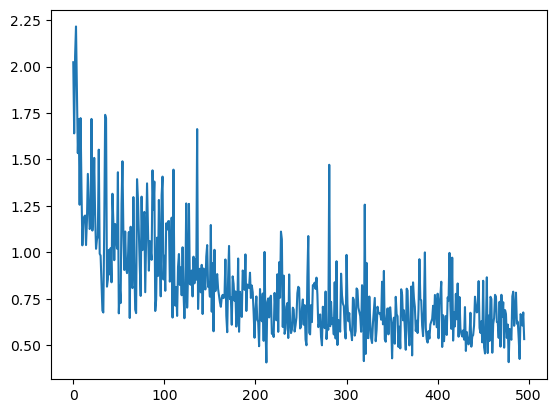

In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

"""
We want to autoencode our motion data, using a transformer model.

We also want to give the model the text description for autoencoding.

We assess loss on MSE of motion data.

The model returns motion.
"""

class Model(nn.Module):
    def __init__(self, latent_dim=512, seq_len=120):
        super().__init__()
        self.seq_len = seq_len
        
        # Encoder
        self.transformer_motion = torch.nn.Transformer(d_model=66, nhead=6, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation='relu')
        self.motion_linear = nn.Linear(66, 15)

        self.text_embedding = nn.Embedding(100194+1, 128)
        self.transformer_text = torch.nn.Transformer(d_model=128, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation='relu')
        self.text_linear = nn.Linear(128, 16)
        self.text_linear2 = nn.Linear(1600, 120)

        self.enc_linear = nn.Linear(1920, latent_dim)


        # Decoder
        self.dec_linear = nn.Linear(latent_dim, seq_len*66)

        self.decoder_transformer = torch.nn.Transformer(d_model=66, nhead=6, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation='relu')




    def encode(self, motion, text_enc, verbose=True):
        motion = motion.view(motion.shape[0], motion.shape[1], -1)
        if verbose: print('motion:', motion.shape)
        motion = self.transformer_motion(motion, motion)
        if verbose: print('motion:', motion.shape)
        motion = self.motion_linear(motion)
        if verbose: print('motion:', motion.shape)


        text_enc = self.text_embedding(text_enc)
        if verbose: print('text_enc:', text_enc.shape)
        text = self.transformer_text(text_enc, text_enc)
        if verbose: print('text:', text.shape)
        text = self.text_linear(text)
        if verbose: print('text:', text.shape)
        text = nn.Flatten()(text)
        if verbose: print('text:', text.shape)
        text = self.text_linear2(text).view(motion.shape[0], motion.shape[1], -1)
        if verbose: print('text:', text.shape)
        

        # print(motion.shape, text.shape)

        x = torch.cat([motion, text], dim=2)
        if verbose: print('x:', x.shape)
        x = nn.Flatten()(x)
        if verbose: print('x:', x.shape)
        x = self.enc_linear(x)
        if verbose: print('x:', x.shape)

        return x
    
    def decode(self, x, verbose=True):
        if verbose: print('x:', x.shape)
        x = self.dec_linear(x)
        if verbose: print('x:', x.shape)
        x = x.view(x.shape[0], self.seq_len, 66)
        if verbose: print('x:', x.shape)
        # print(x.shape)
        x = self.decoder_transformer(x, x)
        if verbose: print('x:', x.shape)
        return x

    def forward(self, motion, text_enc, verbose=False):
        x = self.encode(motion, text_enc, verbose)
        x = self.decode(x, verbose)
        return x.view(x.shape[0], self.seq_len, 22, 3)
    
model = Model()
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)
out = model(motion, text_enc)
device = torch.device('mps')

model = model.to(device)

import torch.optim as optim
crit = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr=1e-4)

losses = []
num_epochs = 2
for epoch in range(num_epochs):
    for i, batch in tqdm(enumerate(dl), total=len(dl), desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
        motion, velocity, text_enc, text = batch
        motion = motion.to(device)
        text_enc = text_enc.to(device)
        out = model(motion, text_enc)
        loss = crit(out, motion)
        # print(loss)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.item())



import matplotlib.pyplot as plt
plt.plot(losses)

    

In [176]:
sample_out = out[0]

from os.path import join as pjoin
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def plot_3d_pose(data, index, ax = None):
    """Plot a 3D pose."""

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    kinematic_chain = [
        [0, 2, 5, 8, 11],
        [0, 1, 4, 7, 10],
        [0, 3, 6, 9, 12, 15],
        [9, 14, 17, 19, 21],
        [9, 13, 16, 18, 20],
    ]

    colors = ["red", "blue", "black", "red", "blue", ]

    for i, (chain, color) in enumerate(zip(kinematic_chain, colors)):
        ax.plot3D(
            data[index, chain, 0],
            data[index, chain, 1],
            data[index, chain, 2],
            linewidth=4.0 if i < 5 else 2.0,
            color=color,
        )

    plt.axis("off")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    return ax

def plot_xzPlane(ax, minx, maxx, miny, minz, maxz):
    ## Plot a plane XZ
    verts = [
        [minx, miny, minz],
        [minx, miny, maxz],
        [maxx, miny, maxz],
        [maxx, miny, minz],
    ]
    xz_plane = Poly3DCollection([verts])
    xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
    ax.add_collection3d(xz_plane)

def init(ax, fig, title, radius=2):
    ax.set_xlim3d([-radius / 2, radius / 2])
    ax.set_ylim3d([0, radius])
    ax.set_zlim3d([0, radius])
    # print(title)
    title_sp = title.split(" ")
    if len(title_sp) > 10:
        title = "\n".join([" ".join(title_sp[:10]), " ".join(title_sp[10:])])
    fig.suptitle(title, fontsize=20)
    ax.grid(b=False)

def plot_trajec(trajec, index, ax):
    ax.plot3D(
        trajec[:index, 0] - trajec[index, 0],
        np.zeros_like(trajec[:index, 0]),
        trajec[:index, 1] - trajec[index, 1],
        linewidth=1.0,
        color="blue",
    )



def plot_3d_motion_animation(data, title, figsize=(10, 10), fps=20, radius=2, save_path='test.mp4', velocity=False, save_path_2=None):
    
    #     matplotlib.use('Agg')
    data = data.copy().reshape(len(data), -1, 3)  # (seq_len, joints_num, 3)

    if velocity:
        data = np.cumsum(data, axis=0)

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111, projection="3d")
    init(ax, fig, title, radius)
    MINS, MAXS = data.min(axis=0).min(axis=0), data.max(axis=0).max(axis=0)

    data[:, :, 1] -= MINS[1]  # height offset
    trajec = data[:, 0, [0, 2]]

    data[..., 0] -= data[:, 0:1, 0]  # centering
    data[..., 2] -= data[:, 0:1, 2]  # centering

    def update(index):
        # ax.dist = 7.5
        def do_it_all(data, index, ax):
            ax.view_init(elev=120, azim=-90)
            plot_xzPlane(ax,
                MINS[0] - trajec[index, 0],
                MAXS[0] - trajec[index, 0],
                0,
                MINS[2] - trajec[index, 1],
                MAXS[2] - trajec[index, 1],
            )

            if index > 1:
                plot_trajec(trajec, index, ax)

            ax.set_xlim3d([-radius / 2, radius / 2])
            ax.set_ylim3d([0, radius])
            ax.set_zlim3d([0, radius])

            
            plot_3d_pose(data, index, ax)

        ax.clear()
        do_it_all(data, index, ax)

        
    ani = FuncAnimation(fig, update, frames=data.shape[0], interval=100 / fps, repeat=False)
    ani.save(save_path, fps=fps)
    if save_path_2:
        ani.save(save_path_2, fps=fps)

    plt.close()

plot_3d_motion_animation(out[0].cpu().detach().numpy(), text[0].split('#')[0], 
                         figsize=(10, 10), fps=20, radius=2, save_path=f"recon_test.mp4", velocity=False)

'the man is making poses with his legs#the/DET man/NOUN is/AUX make/VERB pose/NOUN with/ADP his/DET leg/NOUN#0.0#0.0\n'